### Bayesian Data Analysis, 3rd ed
##  Chapter 5, demo 1

원저자:
- Aki Vehtari aki.vehtari@aalto.fi
- Tuomas Sivula tuomas.sivula@aalto.fi

2차저자:
- 민태규
- 문현지

쥐 실험 예제를 통해 알아보는 계층모형 (BDA3, p. 102).

In [1]:
import numpy as np
from scipy.stats import beta
from scipy.special import gammaln

%matplotlib inline
import matplotlib.pyplot as plt

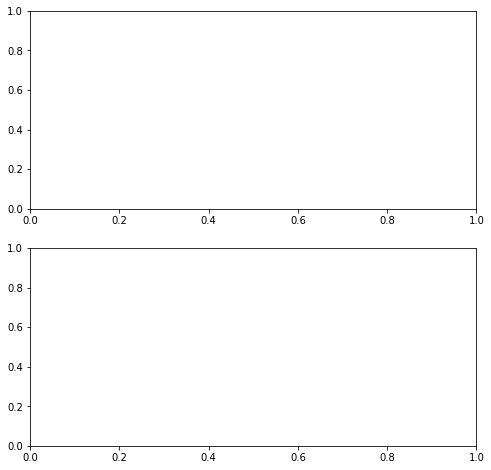

In [2]:
# 'utilities_and_data' 폴더의 경로를 추가합니다.
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# 'utilities_and_data' 폴더에서 plot_tools를 불러옵니다.
import plot_tools

In [3]:
# plot의 기본값 설정을 바꿔줍니다.
plt.rc('font', size=12)

# plot의 배경 스타일을 바꿔줍니다.
plt.style.use(plot_tools.custom_styles['gray_background'])

In [4]:
# 쥐 데이터 (rat data) (BDA3, p. 102)
# y는 악성종양이 생긴 쥐가 몇 마리인지 뜻함.
# n은 약물 투여한 쥐가 총 몇 마리인지 뜻함.
# M은 실험을 시행한 총 횟수를 의미함.

y = np.array([
     0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
     1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
     5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])

n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])

M = len(y)

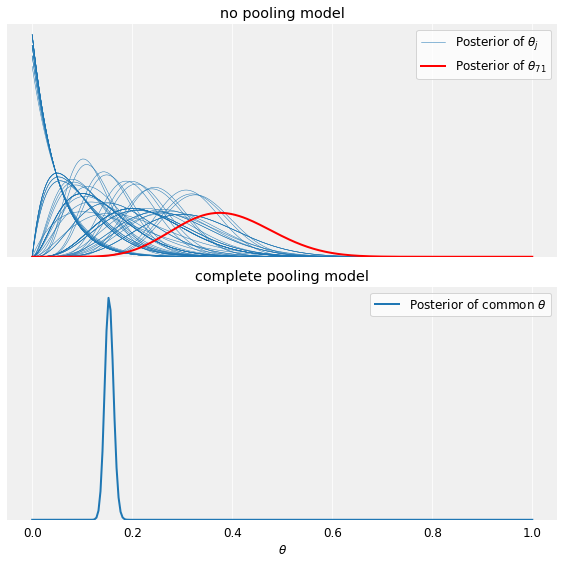

In [17]:
# no pooling 모형과 complete pooling 모형 plot
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

x = np.linspace(0, 1, 250)

# beta(x, a, b, loc, scale) = beta(z, a, b) (z = (x-loc)/scale) 이고 x를 0, 1사이로 생성함

# no pooling 모형
ax = axes[0]
lines = ax.plot(
    x,
    beta.pdf(x[:,None], y[:-1] + 1, n[:-1] - y[:-1] + 1), ### y[:-1] + 1
    color='C0',
    linewidth=0.5
)

# 마지막 line 표시
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.legend(
    (lines[0], lines[-1]),
    (r'Posterior of $\theta_j$',
     r'Posterior of $\theta_{71}$')
)
ax.set_ylim((0, ax.set_ylim()[1]))  
ax.set_yticks(())
ax.set_title('no pooling model')

# complete pooling 모형
ax = axes[1]
ax.plot(
    x,
    beta.pdf(x, y.sum() + 1, n.sum() - y.sum() + 1),
    linewidth=2,
    label=(r'Posterior of common $\theta$')
)
ax.legend()
ax.set_ylim((0, ax.set_ylim()[1]))  
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title('complete pooling model')

fig.tight_layout()

In [14]:
# alpha와 beta 의 주변부분포 계산 위해 계층적 모형을 그리드에서 계산
A = np.linspace(0.5, 6, 100)
B = np.linspace(3, 33, 100)

# 수치적 정확성을 위해 log형태로 계산 (식 5.7)
# 로그 사후분포 구하기 위해 사전분포와 가능도의 로그값을 합
lp = (
  - 5/2 * np.log(A + B[:,None])
  + np.sum(
        gammaln(A + B[:,None])
      - gammaln(A)
      - gammaln(B[:,None])
      + gammaln(A + y[:,None,None])
      + gammaln(B[:,None] + (n - y)[:,None,None])
      - gammaln(A + B[:,None] + n[:,None,None]),
        axis=0
    )
)
# exponentation의 over/underflow을 방지하기 위해 최댓값을 빼줌
lp -= lp.max()
p = np.exp(lp)

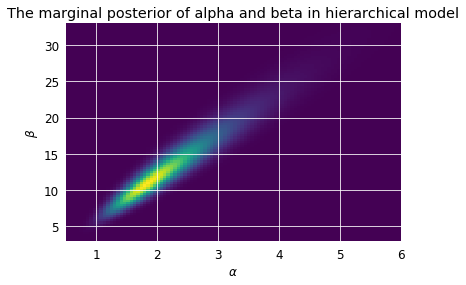

In [7]:
# 계층모형의 hyper-parameter(초모수)인 alpha와 beta에 대해 marginal posterior(주변 사후 분포)를 그려봅시다.

plt.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
plt.xlabel(r'$\alpha$') #x축이 alpha
plt.ylabel(r'$\beta$') #y축이 beta
plt.title('The marginal posterior of alpha and beta in hierarchical model')
plt.grid('off') #격자 없음 모드

In [11]:
# 위 사후분포를 통해 표본 크기 1000의 표본을 만들자.

nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/p.sum()),
    p.shape
)

samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]

# add random jitter, see BDA3 p. 76

samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

지터(jitter) 자세히 알아보기
http://www.ktword.co.kr/abbr_view.php?m_temp1=991

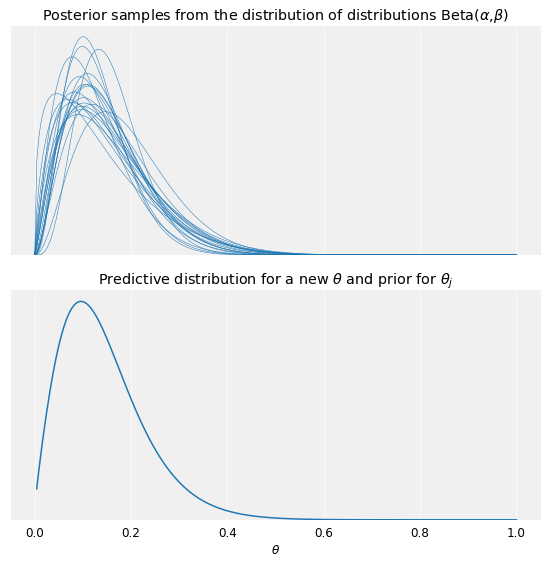

In [9]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

# Beta(alpha,beta)분포로부터 표본을 구한다.
# 이때, alpha와 beta는 사후분포로부터 얻은 표본값들을 이용한다.

ax = axes[0]
ax.plot(
    x,
    beta.pdf(x[:,None], samp_A[:20], samp_B[:20]),
    linewidth=0.5,
    color='C0'
)
ax.set_yticks(())
ax.set_title(
    r'Posterior samples from the distribution of distributions '
    r'Beta($\alpha$,$\beta$)'
)
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

# 위 분포들의 평균이 새 데이터에 대한 예측 분포이다.
# theta, and also the prior distribution for theta_j.
ax = axes[1]
plt.plot(x, np.mean(beta.pdf(x, samp_A[:,None], samp_B[:,None]), axis=0)) #####
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title(
    r'Predictive distribution for a new $\theta$ '
    r'and prior for $\theta_j$'
)
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

fig.tight_layout()

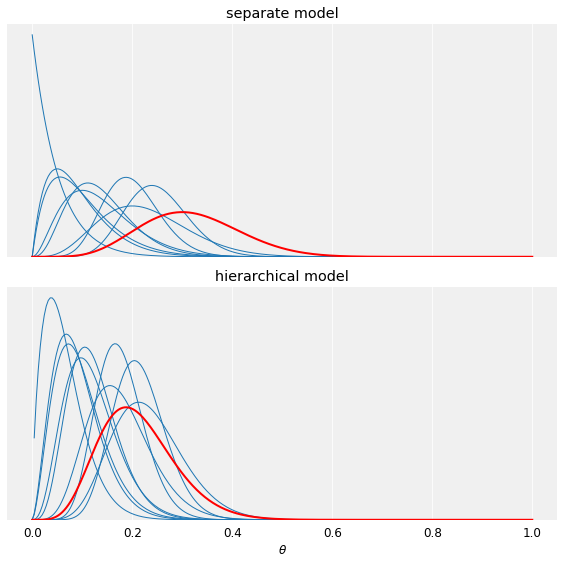

In [18]:
# 그리고 최종적으로 separate모형과 계층모형을 비교하자.
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
x = np.linspace(0, 1, 250)

# 먼저, separate모형부터 그리자.
ax = axes[0]

# note that for clarity only every 7th distribution is plotted
lines = ax.plot(
    x,
    beta.pdf(x[:,None], y[7:-1:7] + 1, n[7:-1:7] - y[7:-1:7] + 1), ### y[7:-1:7]와 y[7::7]의 차이
    color='C0',
    linewidth=1
)

lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.set_yticks(())
ax.set_title('separate model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

# 이번에는 계층모형을 그려본다. 이 theta_j에 대한 주변 사후 분포.
# separate모형보다 좀 더 narrow한 걸 확인할 수 있다.
ax = axes[1]
#
# note that for clarity only every 7th distribution is plotted
lines = ax.plot(
    x,
    np.mean(
        beta.pdf(
            x[:,None],
            y[7::7] + samp_A[:,None,None],
            n[7::7] - y[7::7] + samp_B[:,None,None]
        ),
        axis=0
    ),
    color='C0',
    linewidth=1,
)
# highlight the last line
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title('hierarchical model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

fig.tight_layout()